## Домашнее задание №3

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [ ]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1: 
Вернемся к задаче распознавания рукописных цифр, рассмотренной на первом занятии. Все также будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на пример, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

Text(0.5, 1.0, 'Image label: 3')

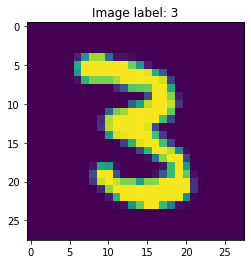

In [ ]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

In [ ]:
print(f'train dataset size: {len(train_mnist_data)}\ntest dataset size: {len(test_mnist_data)}')

train dataset size: 60000
test dataset size: 10000


Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [ ]:
# Creating model instance

N_FEATURES_SMALL = 28*28
N_CLASSES_SMALL = 10

def create_model(activation, hid_size=50, num_features=N_FEATURES_SMALL, n_out=N_CLASSES_SMALL):
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(num_features, hid_size))
    model.add_module('activation1', activation())
    model.add_module('l2', nn.Linear(hid_size, hid_size))
    model.add_module('activation2', activation())
    model.add_module('l3', nn.Linear(hid_size, n_out))

    return model

In [ ]:
model = create_model(nn.ReLU)

Локальные тесты для проверки вашей модели доступны ниже:

In [ ]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)    
except Exception as e:
    print('Something is wrong with the model')
    raise e
    
    
assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. В качестве примера можете воспользоваться ноутбуком с занятия №1. Также рекомендуем поработать с различными оптимизаторами.

In [ ]:
# your code here

NUM_EPOCH = 5

def train_model(model):
    loss_function = nn.CrossEntropyLoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.1)
    
    
    loss_history, var_layer_1, var_layer_2, var_layer_3 = [], [], [], []

    for epoch_num in range(NUM_EPOCH):
      for _i, batch in enumerate(train_data_loader):

        x_batch, y_batch = batch

        opt.zero_grad()

        y_predicted = model(x_batch.reshape(-1, 784))

        loss = loss_function(y_predicted, y_batch)

        reg = 0.01 * (torch.norm(model[0].weight) \
                      + torch.norm(model[2].weight) \
                      + torch.norm(model[4].weight))
        loss += reg
        loss.backward()
        opt.step()

        loss_history.append(loss.item()) # Always use .item() to store scalars in logs!
        
        var_layer_1.append(torch.sum(torch.abs(model[0].weight.grad)).item()/model[0].weight.shape[0])
        var_layer_2.append(torch.sum(torch.abs(model[2].weight.grad)).item()/model[2].weight.shape[0])
        var_layer_3.append(torch.sum(torch.abs(model[4].weight.grad)).item()/model[4].weight.shape[0])

    return model, loss_history, var_layer_1, var_layer_2, var_layer_3

In [ ]:
out = train_model(model)

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [ ]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [ ]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.97582


In [ ]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [ ]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9688


Проверка, что необходимые пороги пройдены:

In [ ]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw03_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw03_mnist/hw03_data_dict.npy

--2022-12-02 11:10:52--  https://raw.githubusercontent.com/girafe-ai/ml-course/msu_branch/homeworks/hw03_mnist/hw03_data_dict.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272438 (6.0M) [application/octet-stream]
Saving to: ‘hw03_data_dict.npy’

hw03_data_dict.npy  100%[===================>]   5.98M  --.-KB/s    in 0.02s   

2022-12-02 11:10:52 (275 MB/s) - ‘hw03_data_dict.npy’ saved [6272438/6272438]



In [ ]:
# do not change the code in the block below
# __________start of block__________
import os

assert os.path.exists('hw03_data_dict.npy'), 'Please, download `hw03_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))
    
    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

loaded_data_dict = np.load('hw03_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])).numpy(),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test'])).numpy()
}

np.save('submission_dict_hw03.npy', submission_dict, allow_pickle=True)
print('File saved to `submission_dict_hw03.npy`')
# __________end of block__________

File saved to `submission_dict_hw03.npy`


На этом задание завершено. Поздравляем!